In [172]:
import numpy as np
from sympy import symbols, Eq, solve, exp, I as j
import matplotlib.pyplot as plt

# Define circuit parameters
V01_val = 48  # Voltage amplitude for first circuit (V)
V02_val = 48  # Voltage amplitude for second circuit (V)
R1_val, R2_val = 0.26, 0.26  # Resistances (ohms)
L1_val, L2_val = 44.45e-6, 44.45e-6  # Inductances (H)
C1_val, C2_val = 468e-9, 468e-9  # Capacitances (F)
k = 0.001  # Coupling coefficient
M_val = k * (L1_val * L2_val)**(1/2)  # Mutual inductance (H)
fm = 100  # Modulation frequency (Hz)
fc = 34.63e3  # Carrier frequency (Hz)
omega_val = 2 * np.pi * fc  # Carrier angular frequency (rad/s)
omega_mod = 2 * np.pi * fm  # Modulation angular frequency (rad/s)

# Define symbolic variables
omega, R1, L1, C1, omega_res = symbols('omega R1 L1 C1 omega_res', real=True)
V1, V2, I1, I2 = symbols('V1 V2 I1 I2', complex=True)

# Impedance of the RLC circuit: Z1 = R1 + jωL1 - j/(ωC1)
Z1 = R1 + j * omega * L1 - j / (omega * C1)

# Prepare for plotting the impedance magnitude
Z1_values = []
omega_values = []
# Calculate and store the impedance magnitude over a frequency range
for omega_val in np.arange(0, omega_val * 2, 100):
    Z1_val = Z1.subs({R1: R1_val, L1: L1_val, C1: C1_val, omega: omega_val})  # Substitute values into Z1
    Z1_values.append(np.abs(Z1_val))
    omega_values.append(omega_val)

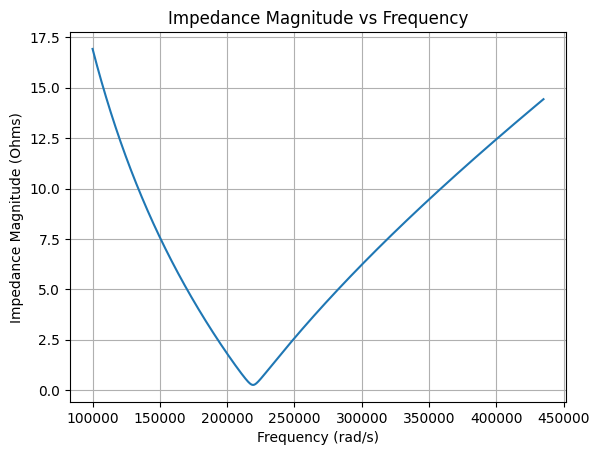

In [173]:
# Plot the impedance magnitude vs frequency
plt.figure()
plt.plot(omega_values[1000:],Z1_values[1000:])
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Impedance Magnitude (Ohms)')
plt.title('Impedance Magnitude vs Frequency')
plt.grid(True)
plt.show()

We now want to find the resonance frequency $\omega_0$ . We can only test in descrete frequency steps and we want the search to be as efficient as possible. I am proposing a line search method with wich we can easily find the minimum of the function $Z(\omega)$.

In [185]:
import scipy.optimize as opt
def impedance_magnitude(omega_val):
    Z1_val = Z1.subs({R1: R1_val, L1: L1_val, C1: C1_val, omega: omega_val})
    return float(abs(Z1_val))

def golden_section_search(f, a, b, tol=1e-5):
    #phi = (np.sqrt(5) - 1) / 2  # Golden ratio constant (~0.618)
    phi = 0.9
    
    # Initial points
    x1 = b - phi * (b - a)
    x2 = a + phi * (b - a)
    
    # Evaluate function at initial points
    f1 = f(x1)
    f2 = f(x2)
    i = 0
    # Iteratively narrow down the interval
    while abs(b - a) > tol:
        i = i + 1
        if f1 < f2:
            b = x2
            x2 = x1
            f2 = f1
            x1 = b - phi * (b - a)
            f1 = f(x1)
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + phi * (b - a)
            f2 = f(x2)
    
    # The minimum is approximately at the midpoint of [a, b]
    return (a + b) / 2, i

# frequency range for optimization
omega_min = 200000
omega_max = 250000

# Find the minimum using the Golden Section Search
optimal_omega, no_searches = golden_section_search(impedance_magnitude, omega_min, omega_max)

# Calculate the minimum impedance
min_impedance = impedance_magnitude(optimal_omega)

print(f"The minimum impedance magnitude is {min_impedance:.4f} at omega = {optimal_omega:.2f} rad/s")
omega_0 = 1/(L1_val * C1_val)**(1/2)
print(f"Theoretical value of omega_0 is {omega_0:.2f} rad/s")
print(f"The number of searches required is {no_searches}")

The minimum impedance magnitude is 1.3586 at omega = 204763.16 rad/s
Theoretical value of omega_0 is 219250.80 rad/s
The number of searches required is 173


### 1. Get $R_{est}$ from $R_{est}=Z(\omega = \omega_0)$
(R_est = imedance at resonance frequency, because inductiove and capacitive impedance are vanising there)

In [187]:
omega_0 = 1/(L1_val*C1_val)**(1/2)
print(omega_0)
R_est = Z1.subs({R1: R1_val, L1: L1_val, C1: C1_val, omega: omega_0}) 
print(abs(R_est))

219250.80207982476
0.260000000000000


## 2. Get C and L

measure the Voltage and current at a frequency $\omega_1$ (not resonance frequency). 

In [175]:
from sympy import symbols, Eq, solve, I, pi

# Define symbolic variables
R1, L1, C1, Z1, I1, V1, omega, omega_res = symbols('R1 L1 C1 Z1 I1 V1 omega omega_res')
Z1 = R1 + I*(omega*L1 - 1/(omega*C1))  # Impedance of a series RLC circuit

# Define equations (fixing the physical model)
eq1 = Eq(Z1, R1 + I*(omega*L1 - 1/(omega*C1)))# impedance equation for a series RLC circuit
eq2 = Eq(Z1, V1/I1)  # Ohm's law (V = I*Z)
eq3 = Eq(omega_res, 1/(C1*L1)**(1/2))  # resonance condition

# Solve the system of equations
solutions = solve([eq1, eq2, eq3], (L1, C1))
L1_est, C1_est = solutions[0]

print("L1=", L1_est)
print("C1=", C1_est)

V1_val = 48  # Voltage amplitude (V)
omega_resonance = 1/(L1_val*C1_val)**(1/2)  # Resonance angular frequency (rad/s)
omega_test = 2*pi*2000  # test with 1 kHz frequency

# Substitute into impedance equation
Z1_test = Z1.subs({R1: R1_val, L1: L1_val, C1: C1_val, omega: omega_test})
I1_test = V1_val/Z1_test

# Evaluate estimates for L1 and C1 at specific values
L1_est_val = L1_est.evalf(subs={R1: R1_val, omega: omega_test, V1: 48, omega_res: omega_resonance, I1: I1_test})
C1_est_val = C1_est.evalf(subs={R1: R1_val, omega: omega_test, V1: 48, omega_res: omega_resonance, I1: I1_test})

print("L1_est_val=", abs(L1_est_val), "L1_val=", L1_val)
print("C1_est_val=", abs(C1_est_val), "C1_val=", C1_val)

L1= I*omega*(I1*R1 - V1)/(I1*(omega - omega_res)*(omega + omega_res))
C1= I*I1*(-omega**2 + omega_res**2)/(omega*omega_res**2*(I1*R1 - V1))
L1_est_val= 4.44500000000000e-5 L1_val= 4.445e-05
C1_est_val= 4.68000000000000e-7 C1_val= 4.68e-07
